1. Here I am trying to implement the [Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](http://https://arxiv.org/pdf/1609.05158.pdf) paper on Breast Histopathology Images.

2. Here authors have proposed sub-pixel convolution layer which learns an array of upscaling filters to upscale the final Low Resolution feature maps into the High Resolution output. This effectively helps to eliminate bicubic filter in the Super Resolution pipeline with more complex upscaling filters specifically trained for each feature map, whilst also reducing the computational complexity of the overall Super Resolution operation. 

In [17]:
# Import all the necessary libraries

import tensorflow as tf

import os
import math
import numpy as np
import imageio

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing import image_dataset_from_directory

from IPython.display import display

### Define image data generators to load and preprocess the images

In [18]:
img_size = 50
downscale_factor = 2
input_size = img_size // downscale_factor
batch_size = 8
root_dir = '../input/bhp-images/BHPIDC20/'

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(img_size, img_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(img_size, img_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 10456 files belonging to 3 classes.
Using 8365 files for training.
Found 10456 files belonging to 3 classes.
Using 2091 files for validation.


### Normalize the pixels for training and validation images

In [19]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

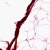

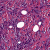

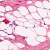

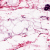

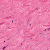

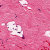

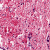

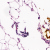

In [20]:
for batch in train_ds.take(1):
    for img in batch:
        display(array_to_img(img))

### Here we have prepared a dataset of test image paths that we will use for visual evaluation at the end of this example.

In [21]:
test_0_path = os.path.join(root_dir, "test/0")

test_img_0_paths = sorted(
    [
        os.path.join(test_0_path, fname)
        for fname in os.listdir(test_0_path)
        if fname.endswith(".png")
    ]
)


In [22]:
len(test_img_0_paths)

240

In [23]:
test_1_path = os.path.join(root_dir, "test/1")

test_img_1_paths = sorted(
    [
        os.path.join(test_1_path, fname)
        for fname in os.listdir(test_1_path)
        if fname.endswith(".png")
    ]
)


In [24]:
len(test_img_1_paths)

216

### Here we define functions to process the input images.

1. First, we convert our images from the RGB color space to the YUV colour space.
2. We take input data (low-resolution images), we crop the image, retrieve the y channel (luninance), and resize it. We only consider the luminance channel in the YUV color space because humans are more sensitive to luminance change.
3. For the target data (high-resolution images), we just crop the image and retrieve the y channel.

In [25]:
# Use TF Ops to process.
def process_input(input, input_size, downscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, downscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, downscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

### Visualize input images after processing them. And we will also look into target images

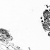

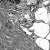

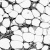

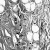

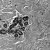

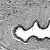

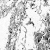

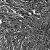

In [26]:
for batch in train_ds.take(1):
    for img in batch[0]:
        display(array_to_img(img))
    for img in batch[1]:
        display(array_to_img(img))

### Define Our CNN Model Architecture

In [27]:
def get_model(downscale_factor=4, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (downscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, downscale_factor)

    return keras.Model(inputs, outputs)

### Here we have defined some utility functions to monitor our results

1. plot_results to plot an save an image.
2. get_lowres_image to convert an image to its low-resolution version.
3. upscale_image to turn a low-resolution image to a high-resolution version reconstructed by the model. In this function, we use the y channel from the YUV color space as input to the model and then combine the output with the other channels to obtain an RGB image.

In [28]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    plt.show()


def get_lowres_image(img, downscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // downscale_factor, img.size[1] // downscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

### Here we have defined callbacks to monitor training

1. The ESPCNCallback object will compute and display the PSNR metric. 
2. This is the main metric we use to evaluate super-resolution performance.

In [29]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(test_img_0_paths[0]), downscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [30]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(downscale_factor=downscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 1)]   0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, None, None, 64)    1664      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 64)    36928     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 32)    18464     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, None, None, 4)     1156      
_________________________________________________________________
tf.nn.depth_to_space_1 (TFOp (None, None, None, 1)     0         
Total params: 58,212
Trainable params: 58,212
Non-trainable params: 0
_______________________________________________________

Epoch 1/100
1046/1046 - 39s - loss: 0.0069 - val_loss: 0.0048
Mean PSNR for epoch: 23.20


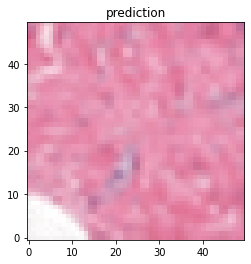

Epoch 2/100
1046/1046 - 10s - loss: 0.0031 - val_loss: 0.0030
Mean PSNR for epoch: 25.23
Epoch 3/100
1046/1046 - 21s - loss: 0.0031 - val_loss: 0.0030
Mean PSNR for epoch: 25.23
Epoch 4/100
1046/1046 - 10s - loss: 0.0030 - val_loss: 0.0030
Mean PSNR for epoch: 25.27
Epoch 5/100
1046/1046 - 9s - loss: 0.0030 - val_loss: 0.0029
Mean PSNR for epoch: 25.39
Epoch 6/100
1046/1046 - 9s - loss: 0.0029 - val_loss: 0.0029
Mean PSNR for epoch: 25.45
Epoch 7/100
1046/1046 - 9s - loss: 0.0029 - val_loss: 0.0028
Mean PSNR for epoch: 25.50
Epoch 8/100
1046/1046 - 9s - loss: 0.0029 - val_loss: 0.0028
Mean PSNR for epoch: 25.55
Epoch 9/100
1046/1046 - 9s - loss: 0.0028 - val_loss: 0.0028
Mean PSNR for epoch: 25.49
Epoch 10/100
1046/1046 - 9s - loss: 0.0028 - val_loss: 0.0028
Mean PSNR for epoch: 25.55
Epoch 11/100
1046/1046 - 9s - loss: 0.0028 - val_loss: 0.0028
Mean PSNR for epoch: 25.59
Epoch 12/100
1046/1046 - 9s - loss: 0.0028 - val_loss: 0.0028
Mean PSNR for epoch: 25.52
Epoch 13/100
1046/1046 - 9

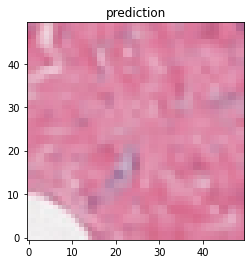

Epoch 22/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.69
Epoch 23/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.67
Epoch 24/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.67
Epoch 25/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.68
Epoch 26/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.70
Epoch 27/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.66
Epoch 28/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.69
Epoch 29/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.74
Epoch 30/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.61
Epoch 31/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.73
Epoch 32/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.69
Epoch 33/100
1046/104

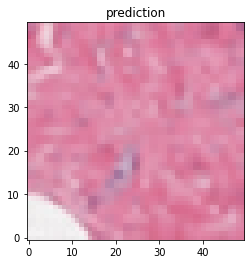

Epoch 42/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 43/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.72
Epoch 44/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.70
Epoch 45/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.73
Epoch 46/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.73
Epoch 47/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.73
Epoch 48/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.73
Epoch 49/100
1046/1046 - 9s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 50/100
1046/1046 - 10s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.71
Epoch 51/100
1046/1046 - 10s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.74
Epoch 52/100
1046/1046 - 10s - loss: 0.0027 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 53/100
1046/

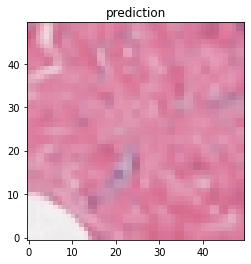

Epoch 62/100
1046/1046 - 10s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.73
Epoch 63/100
1046/1046 - 10s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.77
Epoch 64/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 65/100
1046/1046 - 10s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.77
Epoch 66/100
1046/1046 - 10s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 67/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.77
Epoch 68/100
1046/1046 - 10s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 69/100
1046/1046 - 10s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 70/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.73
Epoch 71/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 72/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 73/100
10

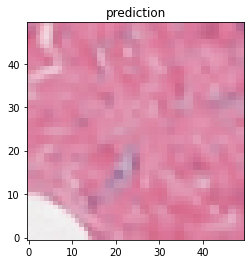

Epoch 82/100
1046/1046 - 10s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.78
Epoch 83/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.77
Epoch 84/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.76
Epoch 85/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 86/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.76
Epoch 87/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.72
Epoch 88/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.78
Epoch 89/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.78
Epoch 90/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.75
Epoch 91/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.77
Epoch 92/100
1046/1046 - 9s - loss: 0.0026 - val_loss: 0.0027
Mean PSNR for epoch: 25.76
Epoch 93/100
1046/10

In [31]:
epochs = 100

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

### Now we run the model prediction and plot the results

In [32]:
# os.mkdir('./HR_0_imgs')
# os.mkdir('./SR_0_imgs')

In [33]:
# os.mkdir('./HR_1_imgs')
# os.mkdir('./SR_1_imgs')

PSNR of low resolution image and high resolution image is 24.4182
PSNR of predict and high resolution is 25.4359


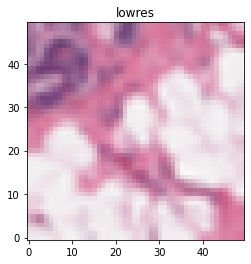

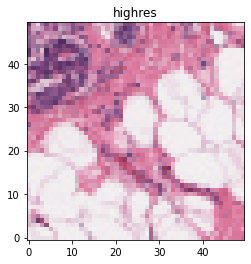

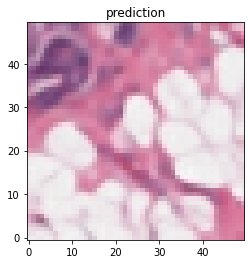

PSNR of low resolution image and high resolution image is 24.9499
PSNR of predict and high resolution is 25.6267


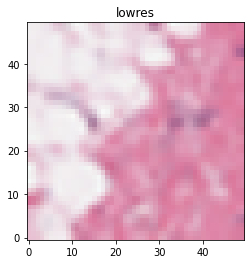

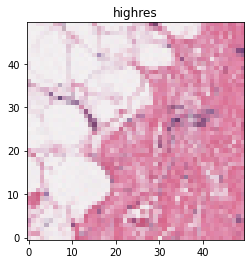

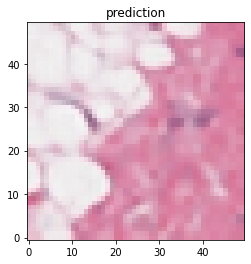

PSNR of low resolution image and high resolution image is 23.7339
PSNR of predict and high resolution is 24.1611


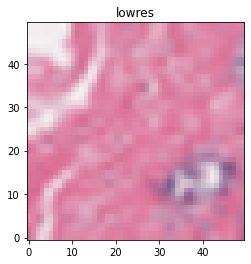

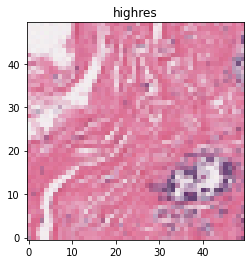

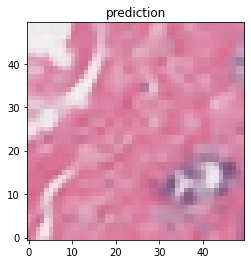

PSNR of low resolution image and high resolution image is 25.1218
PSNR of predict and high resolution is 25.3138


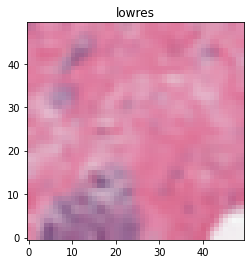

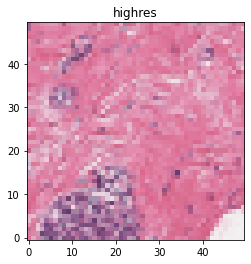

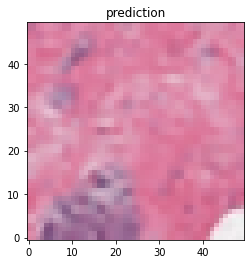

PSNR of low resolution image and high resolution image is 23.7854
PSNR of predict and high resolution is 24.1457


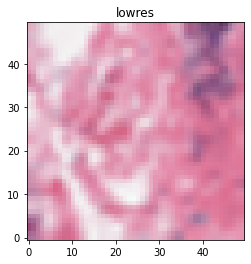

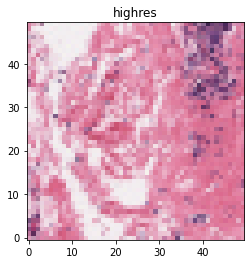

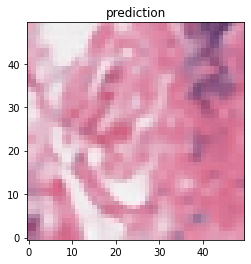

PSNR of low resolution image and high resolution image is 26.1196
PSNR of predict and high resolution is 27.3921


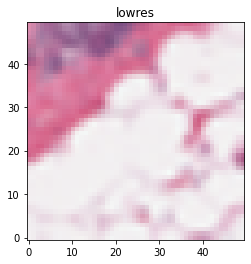

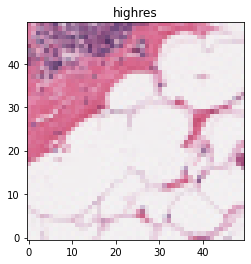

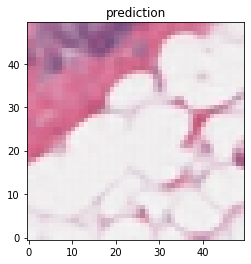

PSNR of low resolution image and high resolution image is 27.4562
PSNR of predict and high resolution is 29.0577


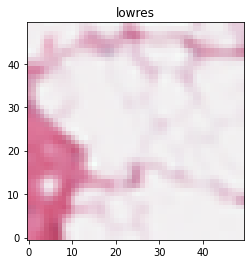

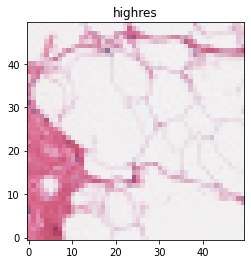

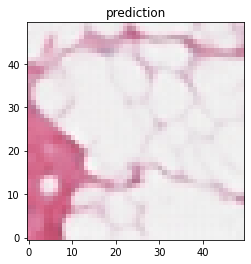

PSNR of low resolution image and high resolution image is 24.9407
PSNR of predict and high resolution is 26.7700


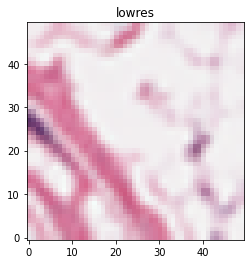

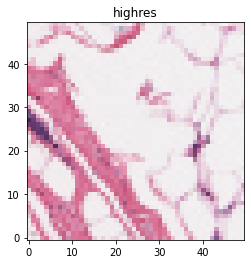

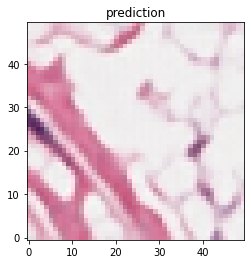

PSNR of low resolution image and high resolution image is 23.4274
PSNR of predict and high resolution is 24.8410


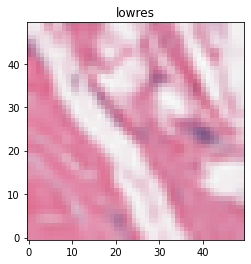

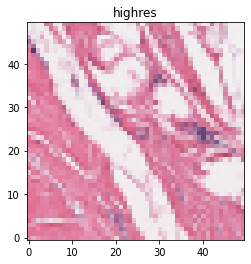

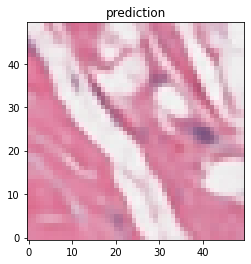

PSNR of low resolution image and high resolution image is 25.3175
PSNR of predict and high resolution is 25.6162


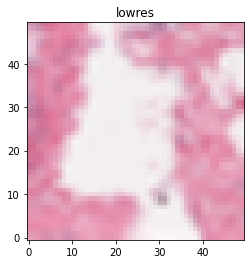

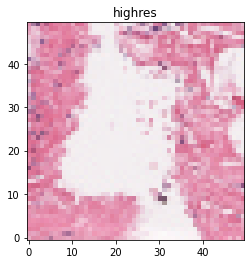

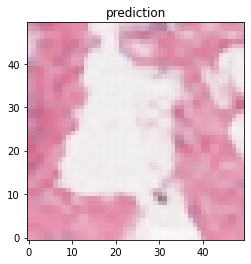

Avg. PSNR of lowres images is 24.9271
Avg. PSNR of reconstructions is 25.8360


In [44]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_0_paths[35:45]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, downscale_factor)
    w = lowres_input.size[0] * downscale_factor
    h = lowres_input.size[1] * downscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    
#     imageio.imwrite('./SR_0_imgs/SR_'+str(index+1)+'.png', np.asarray(prediction, dtype=float))
#     imageio.imwrite('./HR_0_imgs/HR_'+str(index+1)+'.png', np.asarray(highres_img, dtype=float))
    
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

PSNR of low resolution image and high resolution image is 23.2694
PSNR of predict and high resolution is 23.7186


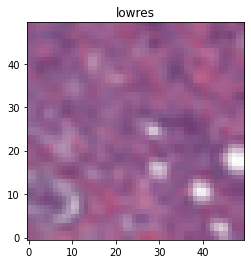

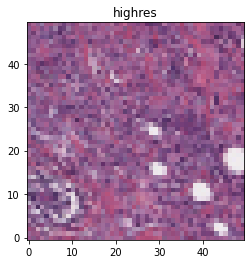

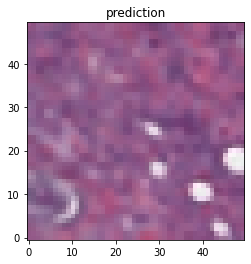

PSNR of low resolution image and high resolution image is 23.8908
PSNR of predict and high resolution is 23.9564


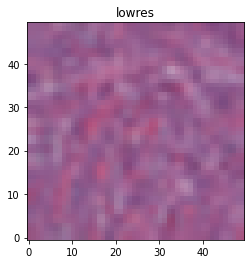

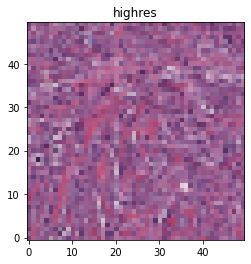

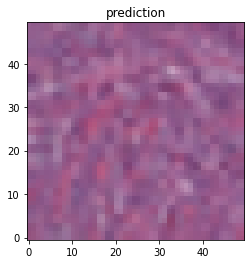

PSNR of low resolution image and high resolution image is 23.0309
PSNR of predict and high resolution is 24.3253


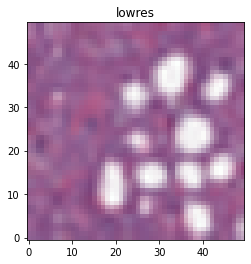

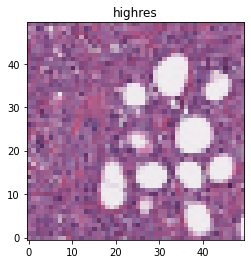

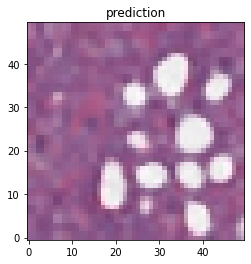

PSNR of low resolution image and high resolution image is 23.3934
PSNR of predict and high resolution is 25.0091


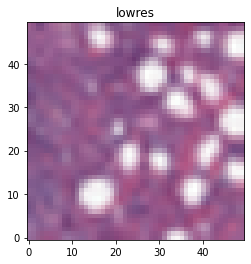

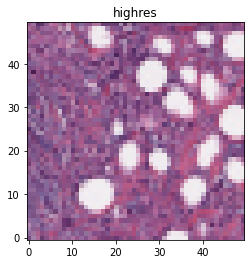

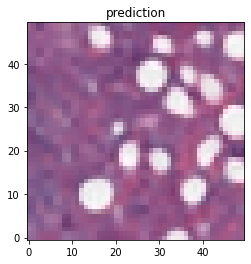

PSNR of low resolution image and high resolution image is 22.7124
PSNR of predict and high resolution is 25.0209


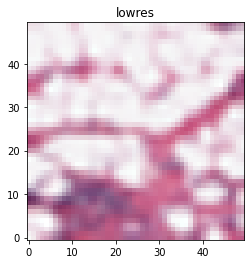

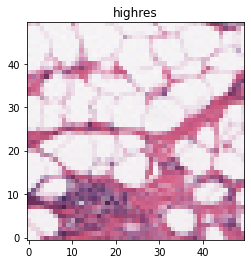

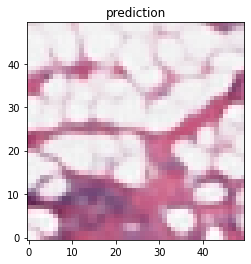

PSNR of low resolution image and high resolution image is 22.4219
PSNR of predict and high resolution is 23.0807


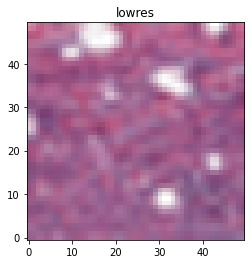

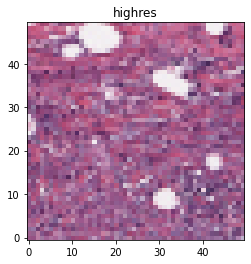

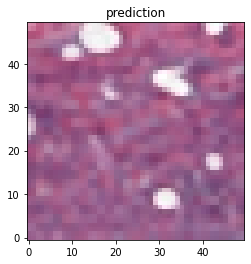

PSNR of low resolution image and high resolution image is 22.4853
PSNR of predict and high resolution is 22.5625


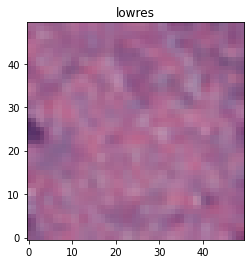

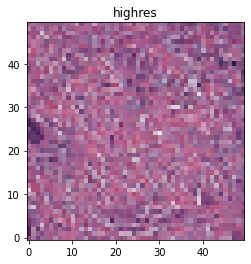

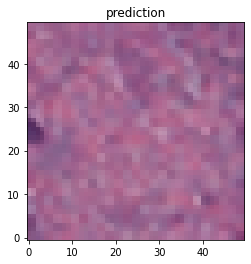

PSNR of low resolution image and high resolution image is 22.5185
PSNR of predict and high resolution is 22.6199


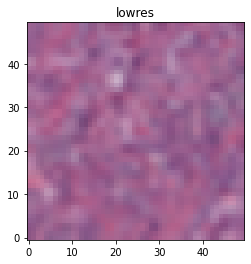

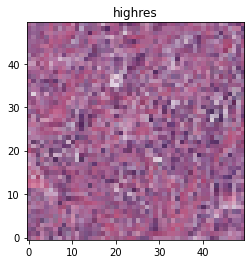

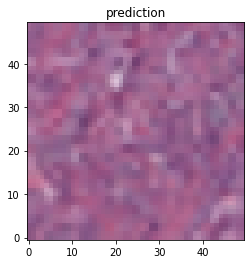

PSNR of low resolution image and high resolution image is 22.7328
PSNR of predict and high resolution is 22.9503


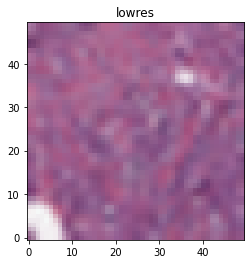

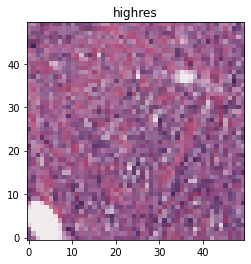

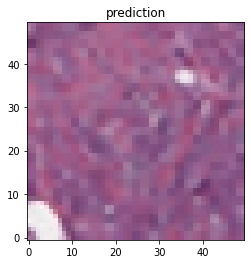

PSNR of low resolution image and high resolution image is 22.7603
PSNR of predict and high resolution is 22.9539


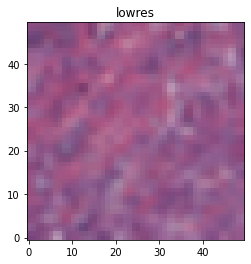

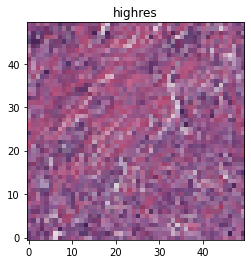

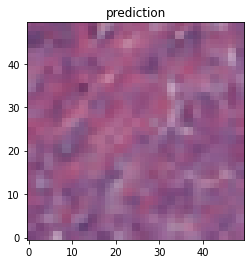

Avg. PSNR of lowres images is 22.9216
Avg. PSNR of reconstructions is 23.6198


In [45]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_1_paths[35:45]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, downscale_factor)
    w = lowres_input.size[0] * downscale_factor
    h = lowres_input.size[1] * downscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    
#     imageio.imwrite('./SR_1_imgs/SR_'+str(index+1)+'.png', np.asarray(prediction, dtype=float))
#     imageio.imwrite('./HR_1_imgs/HR_'+str(index+1)+'.png', np.asarray(highres_img, dtype=float))
    
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [43]:
# %%!

# zip -r HR_0_imgs.zip ./HR_0_imgs

In [40]:
# %%!

# zip -r SR_0_imgs.zip ./SR_0_imgs

In [41]:
# %%!

# zip -r HR_1_imgs.zip ./HR_1_imgs

In [42]:
# %%!

# zip -r SR_1_imgs.zip ./SR_1_imgs